# Etapa 3: Análisis de supervivencia

In [145]:
# Importamos módulos necesarios.
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.plotting import add_at_risk_counts

from src.utils import read_data, save_data

# Aplicamos configuración sobre la visualización de los DataFrames.
pd.set_option('future.no_silent_downcasting', True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

sns.set_theme()

# Ruta de los archivos de origen.
input_path = '../data/processed/'

In [146]:
# Carga de todos los datos.
demographic = read_data(f'{input_path}demographic.csv')
diagnosis_prior = read_data(f'{input_path}diagnosis_prior.csv')
diagnosis_primary = read_data(f'{input_path}diagnosis_primary.csv')
diagnosis_other = read_data(f'{input_path}diagnosis_other.csv')
diagnosis_type = read_data(f'{input_path}diagnosis_type.csv')
treatment_ebrt = read_data(f'{input_path}treatment_ebrt.csv')
treatment_chemo = read_data(f'{input_path}treatment_chemo.csv')
treatment_type = read_data(f'{input_path}treatment_type.csv')
mutation_gene = read_data(f'{input_path}mutation_gene.csv')

In [147]:
print(demographic.shape)
demographic.head()

(185, 15)


,Patient Id,Age,Country Of Residence,Ethnicity,Gender,Race,Diabetes,Chronic Pancreatitis,Alcohol History,Alcohol Intensity,Tobacco Smoking Status,Relative With Cancer,Relative Cancer Type,Vital Status,Overall Survival
0,TCGA-IB-7897,53,Canada,not hispanic or latino,female,white,No,No,Yes,Social Drinker,"Current Reformed Smoker, Duration Not Specified",yes,Melanoma,1,486
1,TCGA-HZ-8315,54,United States,not hispanic or latino,female,white,No,No,NaN,NaN,NaN,NaN,NaN,1,299
2,TCGA-HZ-8636,58,United States,not hispanic or latino,female,white,No,No,NaN,NaN,NaN,NaN,NaN,1,545
3,TCGA-IB-7888,66,Canada,not hispanic or latino,female,black or african american,No,No,NaN,NaN,NaN,NaN,NaN,1,1332
4,TCGA-IB-7893,64,Canada,not hispanic or latino,male,white,Yes,No,Yes,Social Drinker,Current Reformed Smoker for > 15 yrs,yes,Cancer,1,117


In [148]:
demographic.isna().sum()

Patient Id                  0
Age                         0
Country Of Residence        0
Ethnicity                  43
Gender                      0
Race                        5
Diabetes                    0
Chronic Pancreatitis        0
Alcohol History            86
Alcohol Intensity          86
Tobacco Smoking Status     36
Relative With Cancer       72
Relative Cancer Type      121
Vital Status                0
Overall Survival            0
dtype: int64

In [149]:
demographic = demographic[demographic['Patient Id'].isin(mutation_gene.columns[1:-2])].copy()
demographic = demographic.merge(diagnosis_primary[['Patient Id', 'Primary Diagnosis']], on='Patient Id', how='left')
demographic = demographic[demographic['Primary Diagnosis'] == 'Adenocarcinoma Ductal'].copy()

-0.1293961822967381


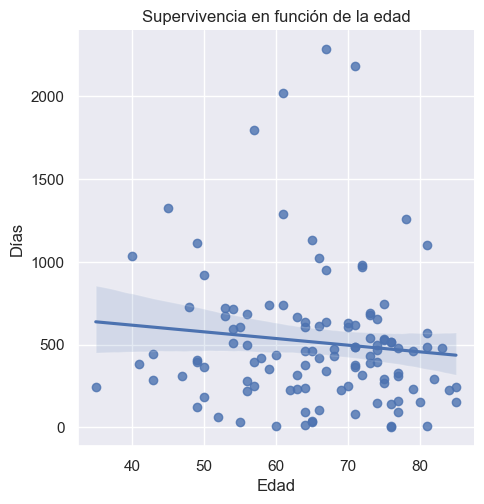

In [150]:
print(demographic['Age'].corr(demographic['Overall Survival'], method='spearman'))
sns.lmplot(data=demographic, y='Overall Survival', x='Age')

plt.title('Supervivencia en función de la edad')
plt.xlabel('Edad')
plt.ylabel('Días')
plt.show()

In [151]:
prediction = demographic[['Age', 'Overall Survival', 'Vital Status']].copy()
prediction.reset_index(inplace=True, drop=True)
prediction.head()

,Age,Overall Survival,Vital Status
0,68,431,1
1,56,277,1
2,50,920,1
3,66,1021,1
4,71,485,1


In [152]:
demographic['Ethnicity'] = demographic['Ethnicity'].fillna('not hispanic or latino')
demographic['Ethnicity'] = demographic['Ethnicity'].str.replace('not hispanic or latino', 'No hispano o latino')\
      .str.replace('hispanic or latino', 'Hispano o latino')

demographic['Race'] = demographic['Race'].fillna('white')
demographic['Race'] = demographic['Race'].str.replace('white', 'Blanca').str.replace('asian', 'Asiática')\
      .str.replace('black or african american', 'Negra o afroamericana')

demographic['Gender'] = demographic['Gender'].str.replace('female', 'Femenino').str.replace('male', 'Masculino')

demographic['Relative With Cancer'] = demographic['Relative With Cancer'].str.replace('yes', 'Si').str.replace('no', 'No').fillna('No')

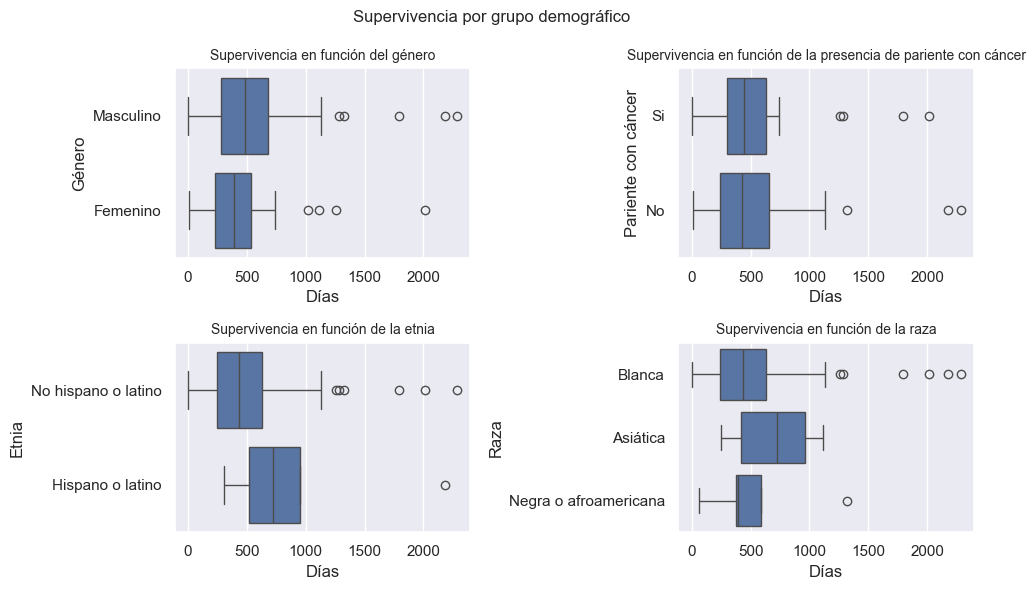

In [153]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))

sns.boxplot(data=demographic, x='Overall Survival', y='Gender', ax=ax[0, 0])
ax[0, 0].set_title('Supervivencia en función del género', fontsize=10)
ax[0, 0].set_xlabel('Días')
ax[0, 0].set_ylabel('Género')

sns.boxplot(data=demographic, x='Overall Survival', y='Relative With Cancer', ax=ax[0, 1])
ax[0, 1].set_title('Supervivencia en función de la presencia de pariente con cáncer', fontsize=10)
ax[0, 1].set_xlabel('Días')
ax[0, 1].set_ylabel('Pariente con cáncer')

sns.boxplot(data=demographic, x='Overall Survival', y='Ethnicity', ax=ax[1, 0])
ax[1, 0].set_title('Supervivencia en función de la etnia', fontsize=10)
ax[1, 0].set_xlabel('Días')
ax[1, 0].set_ylabel('Etnia')

sns.boxplot(data=demographic, x='Overall Survival', y='Race', ax=ax[1, 1])
ax[1, 1].set_title('Supervivencia en función de la raza', fontsize=10)
ax[1, 1].set_xlabel('Días')
ax[1, 1].set_ylabel('Raza')

fig.suptitle('Supervivencia por grupo demográfico', fontsize=12)
fig.tight_layout()

plt.show()

In [154]:
demographic['Alcohol History'] = demographic['Alcohol History'].str.replace('Yes', 'Si').str.replace('no', 'No').fillna('No')

demographic['Tobacco Smoking Status'] = demographic['Tobacco Smoking Status'].fillna('Lifelong Non-Smoker')
demographic['smoking'] = demographic['Tobacco Smoking Status'].apply(lambda x: 'No' if x == 'Lifelong Non-Smoker' else 'Si')

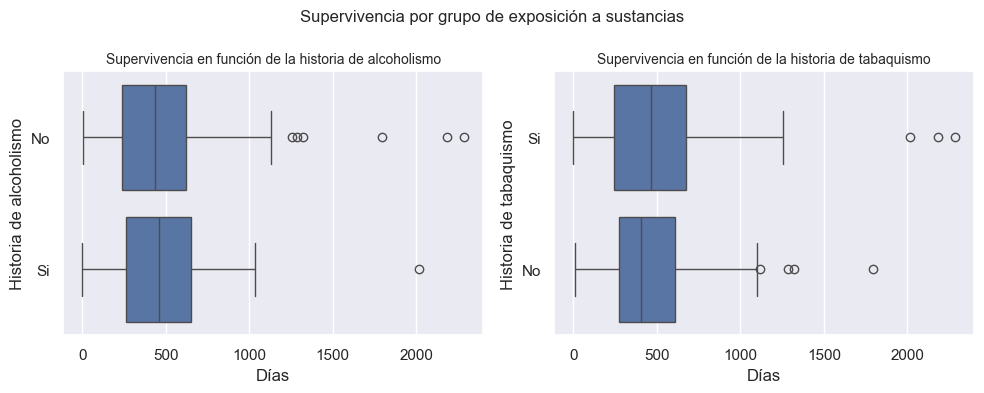

In [155]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.boxplot(data=demographic, x='Overall Survival', y='Alcohol History', ax=ax[0])
ax[0].set_title('Supervivencia en función de la historia de alcoholismo', fontsize=10)
ax[0].set_xlabel('Días')
ax[0].set_ylabel('Historia de alcoholismo')

sns.boxplot(data=demographic, x='Overall Survival', y='smoking', ax=ax[1])
ax[1].set_title('Supervivencia en función de la historia de tabaquismo', fontsize=10)
ax[1].set_xlabel('Días')
ax[1].set_ylabel('Historia de tabaquismo')

fig.suptitle('Supervivencia por grupo de exposición a sustancias', fontsize=12)
fig.tight_layout()

plt.show()

In [156]:
diagnosis_primary.head()

,Patient Id,Ajcc Pathologic Stage,Ajcc Pathologic T,Ajcc Pathologic N,Ajcc Pathologic M,Primary Diagnosis,Residual Disease,Sites Of Involvement,Tumor Grade,Year Of Diagnosis,Lymph Nodes Positive,Maximum Tumor Diameter (cm),Ajcc Pathologic N 8th,Ajcc Pathologic T 8th,Ajcc Pathologic Stage 8th,Gene Mutations
0,TCGA-IB-7897,Estadio II,T3,N1,M0,Adenocarcinoma Ductal,R0,Cabeza,G2,2008.0,2.0,3.5,N1,T2,Estadio II,NaN
1,TCGA-HZ-8315,Estadio II,T3,N0,MX,Adenocarcinoma Ductal,R1,Cabeza,G2,2012.0,0.0,6.0,N0,T3,Estadio II,NaN
2,TCGA-HZ-8636,Estadio IV,T3,N0,M1,Adenocarcinoma Ductal,R1,Cuerpo/Cola,G3,2012.0,0.0,9.0,N0,T3,Estadio IV,NaN
3,TCGA-IB-7888,Estadio II,T3,N0,M0,Adenocarcinoma Ductal,R0,Cabeza,G2,2008.0,0.0,3.0,N0,T2,Estadio I,NaN
4,TCGA-IB-7893,Estadio II,T3,N0,M0,Adenocarcinoma Ductal,R0,Cuerpo/Cola,G3,2009.0,0.0,7.0,N0,T3,Estadio II,NaN


In [157]:
diagnosis_primary.isna().sum()

Patient Id                      0
Ajcc Pathologic Stage           3
Ajcc Pathologic T               1
Ajcc Pathologic N               1
Ajcc Pathologic M               0
Primary Diagnosis               0
Residual Disease               12
Sites Of Involvement            0
Tumor Grade                     0
Year Of Diagnosis               1
Lymph Nodes Positive            4
Maximum Tumor Diameter (cm)    15
Ajcc Pathologic N 8th           0
Ajcc Pathologic T 8th           0
Ajcc Pathologic Stage 8th       0
Gene Mutations                 59
dtype: int64

In [158]:
diagnosis_primary = diagnosis_primary.merge(demographic[['Patient Id', 'Overall Survival', 'Vital Status']], on='Patient Id', how='left')

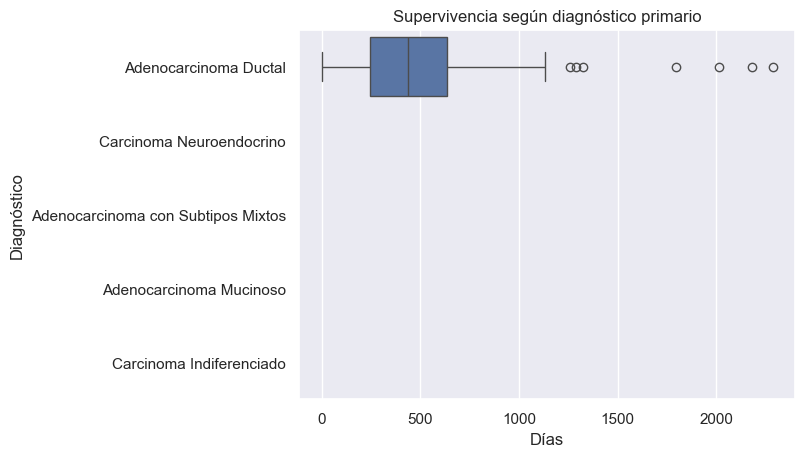

In [159]:
sns.boxplot(data=diagnosis_primary, x='Overall Survival', y='Primary Diagnosis')

plt.title('Supervivencia según diagnóstico primario')
plt.xlabel('Días')
plt.ylabel('Diagnóstico')

plt.show()

In [160]:
diagnosis_primary = diagnosis_primary[diagnosis_primary['Primary Diagnosis'] == 'Adenocarcinoma Ductal'].copy()
diagnosis_primary = diagnosis_primary[diagnosis_primary['Patient Id'].isin(mutation_gene.columns[1:-2])].copy()
diagnosis_primary.shape

(115, 18)

Tiempo medio de supervivencia: 568 días


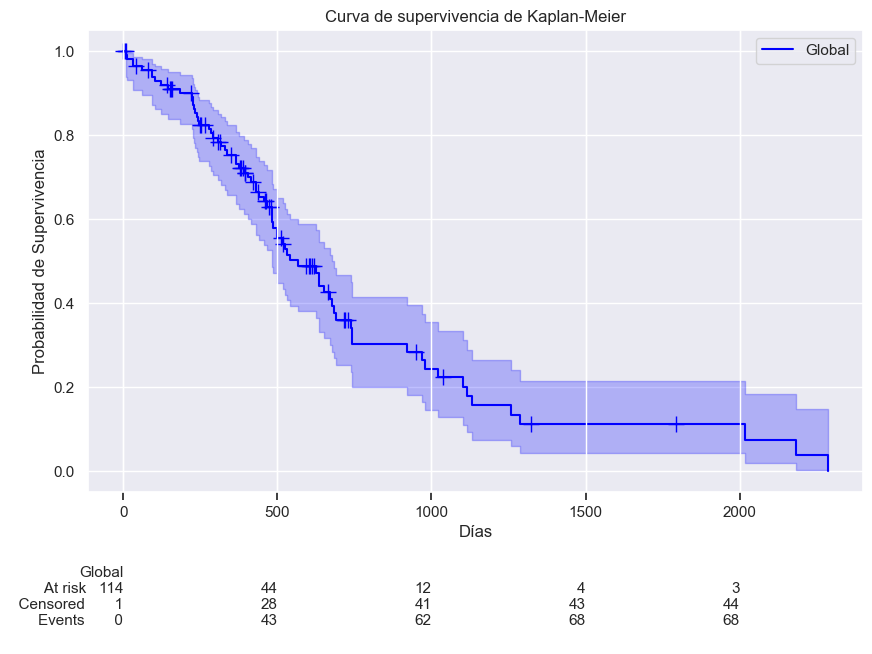

In [161]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
ax = plt.gca()

kmf.fit(diagnosis_primary['Overall Survival'], event_observed=diagnosis_primary['Vital Status'], label="Global")
kmf.plot_survival_function(ax=ax, ci_show=True, color='blue', show_censors=True)
print(f'Tiempo medio de supervivencia: {kmf.median_survival_time_:.0f} días')

add_at_risk_counts(kmf, ax=ax)

ax.set_title('Curva de supervivencia de Kaplan-Meier')
ax.set_xlabel('Días')
ax.set_ylabel('Probabilidad de Supervivencia')

plt.show()

Tiempo medio de supervivencia: 498 días
Tiempo medio de supervivencia: 525 días
Tiempo medio de supervivencia: 541 días
Tiempo medio de supervivencia: inf días
Tiempo medio de supervivencia: 1021 días
Tiempo medio de supervivencia: 485 días
Tiempo medio de supervivencia: 568 días
Tiempo medio de supervivencia: inf días


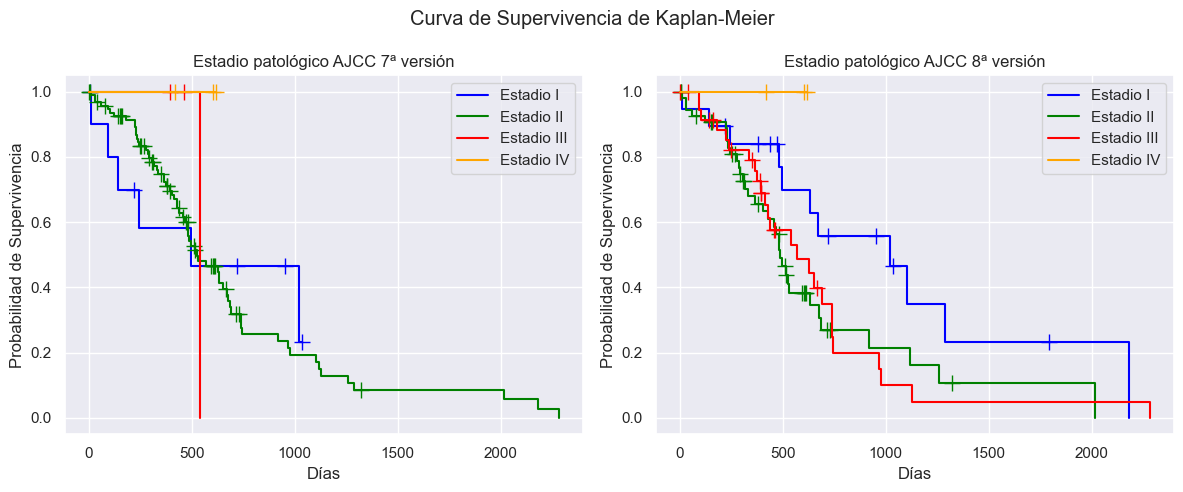

In [162]:
groups = diagnosis_primary['Ajcc Pathologic Stage']

Stage_I = (groups == 'Estadio I')
Stage_II = (groups == 'Estadio II')
Stage_III = (groups == 'Estadio III')
Stage_IV = (groups == 'Estadio IV')

kmf = KaplanMeierFitter()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

kmf.fit(diagnosis_primary.loc[Stage_I, 'Overall Survival'], event_observed=diagnosis_primary.loc[Stage_I, 'Vital Status'])
kmf.plot_survival_function(label="Estadio I", ci_show=False, color='blue', show_censors=True, ax=ax[0])
print(f'Tiempo medio de supervivencia: {kmf.median_survival_time_:.0f} días')

kmf.fit(diagnosis_primary.loc[Stage_II, 'Overall Survival'], event_observed=diagnosis_primary.loc[Stage_II, 'Vital Status'])
kmf.plot_survival_function(label="Estadio II", ci_show=False, color='green', show_censors=True, ax=ax[0])
print(f'Tiempo medio de supervivencia: {kmf.median_survival_time_:.0f} días')

kmf.fit(diagnosis_primary.loc[Stage_III, 'Overall Survival'], event_observed=diagnosis_primary.loc[Stage_III, 'Vital Status'])
kmf.plot_survival_function(label="Estadio III", ci_show=False, color='red', show_censors=True, ax=ax[0])
print(f'Tiempo medio de supervivencia: {kmf.median_survival_time_:.0f} días')

kmf.fit(diagnosis_primary.loc[Stage_IV, 'Overall Survival'], event_observed=diagnosis_primary.loc[Stage_IV, 'Vital Status'])
kmf.plot_survival_function(label="Estadio IV", ci_show=False, color='orange', show_censors=True, ax=ax[0])
print(f'Tiempo medio de supervivencia: {kmf.median_survival_time_:.0f} días')

ax[0].set_title('Estadio patológico AJCC 7ª versión')
ax[0].set_xlabel('Días')
ax[0].set_ylabel('Probabilidad de Supervivencia')

groups = diagnosis_primary['Ajcc Pathologic Stage 8th']

Stage_I = (groups == 'Estadio I')
Stage_II = (groups == 'Estadio II')
Stage_III = (groups == 'Estadio III')
Stage_IV = (groups == 'Estadio IV')

kmf.fit(diagnosis_primary.loc[Stage_I, 'Overall Survival'], event_observed=diagnosis_primary.loc[Stage_I, 'Vital Status'])
kmf.plot_survival_function(label="Estadio I", ci_show=False, color='blue', show_censors=True, ax=ax[1])
print(f'Tiempo medio de supervivencia: {kmf.median_survival_time_:.0f} días')

kmf.fit(diagnosis_primary.loc[Stage_II, 'Overall Survival'], event_observed=diagnosis_primary.loc[Stage_II, 'Vital Status'])
kmf.plot_survival_function(label="Estadio II", ci_show=False, color='green', show_censors=True, ax=ax[1])
print(f'Tiempo medio de supervivencia: {kmf.median_survival_time_:.0f} días')

kmf.fit(diagnosis_primary.loc[Stage_III, 'Overall Survival'], event_observed=diagnosis_primary.loc[Stage_III, 'Vital Status'])
kmf.plot_survival_function(label="Estadio III", ci_show=False, color='red', show_censors=True, ax=ax[1])
print(f'Tiempo medio de supervivencia: {kmf.median_survival_time_:.0f} días')

kmf.fit(diagnosis_primary.loc[Stage_IV, 'Overall Survival'], event_observed=diagnosis_primary.loc[Stage_IV, 'Vital Status'])
kmf.plot_survival_function(label="Estadio IV", ci_show=False, color='orange', show_censors=True, ax=ax[1])
print(f'Tiempo medio de supervivencia: {kmf.median_survival_time_:.0f} días')

ax[1].set_title('Estadio patológico AJCC 8ª versión')
ax[1].set_xlabel('Días')
ax[1].set_ylabel('Probabilidad de Supervivencia')

fig.suptitle('Curva de Supervivencia de Kaplan-Meier')

plt.tight_layout()
plt.show()

Stage I: 19
Stage other: 96
Tiempo medio de supervivencia: 1021 días
Tiempo medio de supervivencia: 525 días


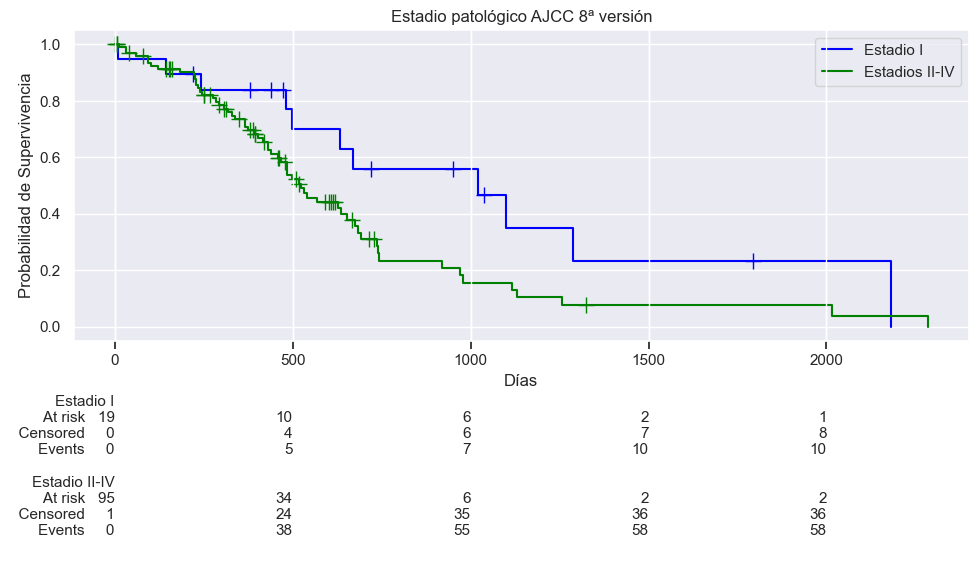

In [163]:
groups = diagnosis_primary['Ajcc Pathologic Stage 8th']

Stage_I = (groups == 'Estadio I')

prediction['Estadio I'] = Stage_I
prediction['Estadio I'] = prediction['Estadio I'].fillna(False).astype(int)

print(f'Stage I: {Stage_I.sum()}')
print(f'Stage other: {groups.shape[0] - Stage_I.sum()}')

kmf = KaplanMeierFitter()
kmf1 = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
ax = plt.gca()

kmf.fit(diagnosis_primary.loc[Stage_I, 'Overall Survival'], event_observed=diagnosis_primary.loc[Stage_I, 'Vital Status'], label="Estadio I")
kmf.plot_survival_function(label="Estadio I", ci_show=False, color='blue', show_censors=True, ax=ax)
print(f'Tiempo medio de supervivencia: {kmf.median_survival_time_:.0f} días')

kmf1.fit(diagnosis_primary.loc[~Stage_I, 'Overall Survival'], event_observed=diagnosis_primary.loc[~Stage_I, 'Vital Status'], label="Estadio II-IV")
kmf1.plot_survival_function(label="Estadios II-IV", ci_show=False, color='green', show_censors=True, ax=ax)
print(f'Tiempo medio de supervivencia: {kmf1.median_survival_time_:.0f} días')

ax.set_title('Estadio patológico AJCC 8ª versión')
ax.set_xlabel('Días')
ax.set_ylabel('Probabilidad de Supervivencia')

add_at_risk_counts(kmf, kmf1, ax=ax)
plt.tight_layout()
plt.show()

In [164]:
df = prediction[['Overall Survival', 'Vital Status', 'Estadio I']]
cph = CoxPHFitter()
cph.fit(df, duration_col='Overall Survival', event_col='Vital Status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 115 total observations, 44 right-censored observations>
             duration col = 'Overall Survival'
                event col = 'Vital Status'
      baseline estimation = breslow
   number of observations = 115
number of events observed = 71
   partial log-likelihood = -261.21
         time fit was run = 2026-02-17 14:43:58 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
Estadio I  0.69      2.00      0.40           -0.10            1.48                0.91                4.40

           cmp to    z    p  -log2(p)
covariate                            
Estadio I    0.00 1.72 0.09      3.54
---
Concordance = 0.53
Partial AIC = 524.42
log-likelihood ratio test = 2.47 on 1 df
-log2(p) of ll-ratio test = 3.11

In [165]:
diagnosis_primary['Tumor Grade'] = diagnosis_primary['Tumor Grade'].str.replace('GX', 'G1')

G1: 15
G2-G3: 100
Tiempo medio de supervivencia: 627 días
Tiempo medio de supervivencia: 541 días


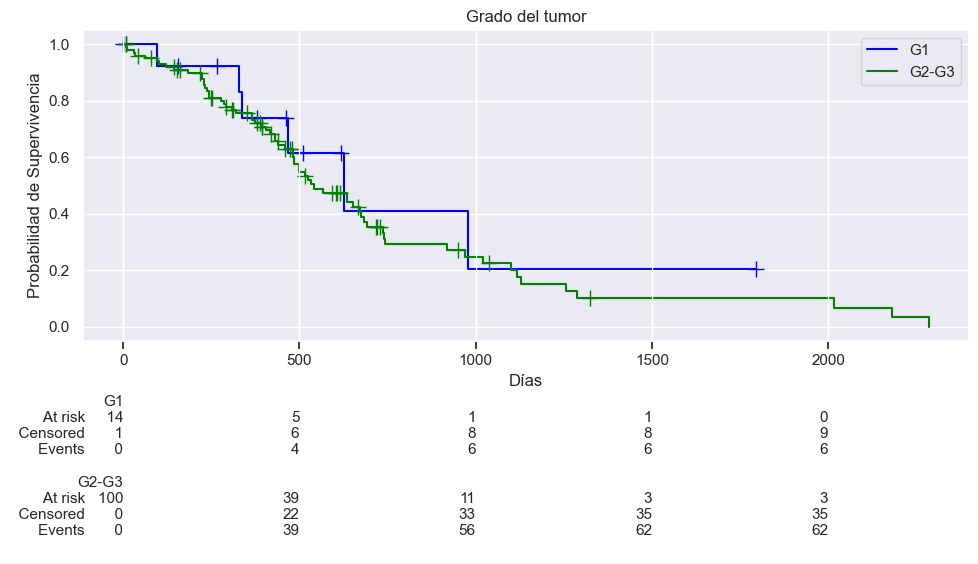

In [166]:
groups = diagnosis_primary['Tumor Grade']

g1 = (groups == 'G1')

prediction['G1'] = g1
prediction['G1'] = prediction['G1'].fillna(False).astype(int)

print(f'G1: {g1.sum()}')
print(f'G2-G3: {groups.shape[0] - g1.sum()}')

kmf = KaplanMeierFitter()
kmf1 = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
ax = plt.gca()

kmf.fit(diagnosis_primary.loc[g1, 'Overall Survival'], event_observed=diagnosis_primary.loc[g1, 'Vital Status'], label="G1")
kmf.plot_survival_function(label="G1", ci_show=False, color='blue', show_censors=True)
print(f'Tiempo medio de supervivencia: {kmf.median_survival_time_:.0f} días')

kmf1.fit(diagnosis_primary.loc[~g1, 'Overall Survival'], event_observed=diagnosis_primary.loc[~g1, 'Vital Status'], label="G2-G3")
kmf1.plot_survival_function(label="G2-G3", ci_show=False, color='green', show_censors=True)
print(f'Tiempo medio de supervivencia: {kmf1.median_survival_time_:.0f} días')


ax.set_title('Grado del tumor')
ax.set_xlabel('Días')
ax.set_ylabel('Probabilidad de Supervivencia')

add_at_risk_counts(kmf, kmf1, ax=ax)
plt.tight_layout()
plt.show()

In [167]:
df = prediction[['Overall Survival', 'Vital Status', 'G1']]
cph = CoxPHFitter()
cph.fit(df, duration_col='Overall Survival', event_col='Vital Status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 115 total observations, 44 right-censored observations>
             duration col = 'Overall Survival'
                event col = 'Vital Status'
      baseline estimation = breslow
   number of observations = 115
number of events observed = 71
   partial log-likelihood = -262.36
         time fit was run = 2026-02-17 14:43:58 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
G1        -0.16      0.85      0.38           -0.91            0.59                0.40                1.81

           cmp to     z    p  -log2(p)
covariate                             
G1           0.00 -0.42 0.68      0.56
---
Concordance = 0.50
Partial AIC = 526.72
log-likelihood ratio test = 0.18 on 1 df
-log2(p) of ll-ratio test = 0.57

In [168]:
diagnosis_primary['Residual Disease'] = diagnosis_primary['Residual Disease'].str.replace('RX', 'R0').fillna('R0')

R0: 77
R1-R2: 38
Tiempo medio de supervivencia: 635 días
Tiempo medio de supervivencia: 484 días


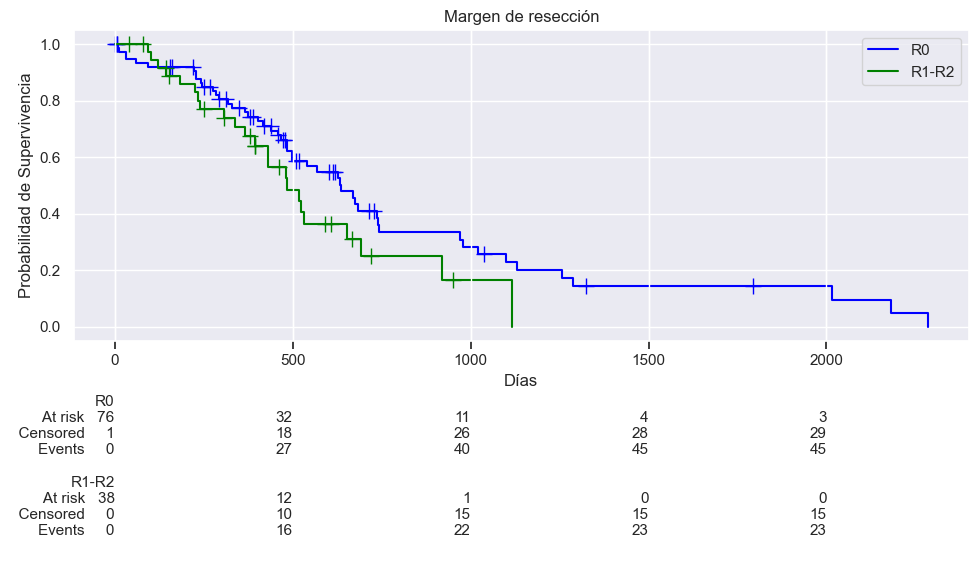

In [169]:
groups = diagnosis_primary['Residual Disease']

r0 = (groups == 'R0')

prediction['R0'] = r0
prediction['R0'] = prediction['R0'].fillna(False).astype(int)

print(f'R0: {r0.sum()}')
print(f'R1-R2: {groups.shape[0] - r0.sum()}')

kmf = KaplanMeierFitter()
kmf1 = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
ax = plt.gca()

kmf.fit(diagnosis_primary.loc[r0, 'Overall Survival'], event_observed=diagnosis_primary.loc[r0, 'Vital Status'], label="R0")
kmf.plot_survival_function(label="R0", ci_show=False, color='blue', show_censors=True, ax=ax)
print(f'Tiempo medio de supervivencia: {kmf.median_survival_time_:.0f} días')

kmf1.fit(diagnosis_primary.loc[~r0, 'Overall Survival'], event_observed=diagnosis_primary.loc[~r0, 'Vital Status'], label="R1-R2")
kmf1.plot_survival_function(label="R1-R2", ci_show=False, color='green', show_censors=True, ax=ax)
print(f'Tiempo medio de supervivencia: {kmf1.median_survival_time_:.0f} días')

ax.set_title('Margen de resección')
ax.set_xlabel('Días')
ax.set_ylabel('Probabilidad de Supervivencia')

add_at_risk_counts(kmf, kmf1, ax=ax)
plt.tight_layout()

plt.show()

In [170]:
df = prediction[['Overall Survival', 'Vital Status', 'R0']]
cph = CoxPHFitter()
cph.fit(df, duration_col='Overall Survival', event_col='Vital Status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 115 total observations, 44 right-censored observations>
             duration col = 'Overall Survival'
                event col = 'Vital Status'
      baseline estimation = breslow
   number of observations = 115
number of events observed = 71
   partial log-likelihood = -262.20
         time fit was run = 2026-02-17 14:43:59 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
R0        -0.17      0.84      0.25           -0.66            0.31                0.52                1.37

           cmp to     z    p  -log2(p)
covariate                             
R0           0.00 -0.70 0.48      1.05
---
Concordance = 0.53
Partial AIC = 526.40
log-likelihood ratio test = 0.50 on 1 df
-log2(p) of ll-ratio test = 1.05

In [171]:
diagnosis_primary['Sites Of Involvement'] = diagnosis_primary['Sites Of Involvement'].str.replace('No especificado', 'Cabeza')

Cabeza: 94
Otros sitios: 21
Tiempo medio de supervivencia: 525 días
Tiempo medio de supervivencia: 676 días


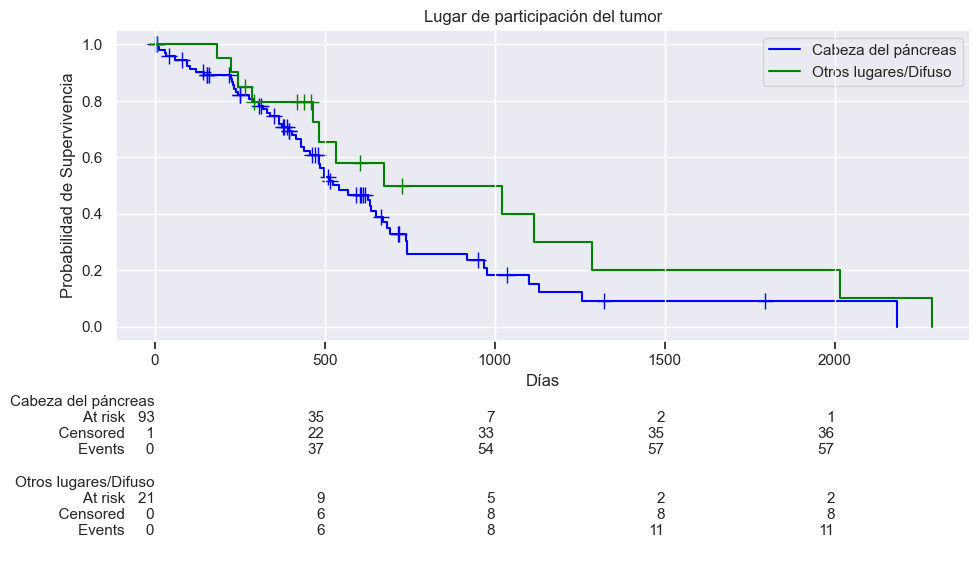

In [172]:
groups = diagnosis_primary['Sites Of Involvement']

head = (groups == 'Cabeza')

prediction['Cabeza'] = head
prediction['Cabeza'] = prediction['Cabeza'].fillna(False).astype(int)

print(f'Cabeza: {head.sum()}')
print(f'Otros sitios: {groups.shape[0] - head.sum()}')

kmf = KaplanMeierFitter()
kmf1 = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
ax = plt.gca()

kmf.fit(diagnosis_primary.loc[head, 'Overall Survival'], event_observed=diagnosis_primary.loc[head, 'Vital Status'], label="Cabeza del páncreas")
kmf.plot_survival_function(label="Cabeza del páncreas", ci_show=False, color='blue', show_censors=True)
print(f'Tiempo medio de supervivencia: {kmf.median_survival_time_:.0f} días')

kmf1.fit(diagnosis_primary.loc[~head, 'Overall Survival'], event_observed=diagnosis_primary.loc[~head, 'Vital Status'], label="Otros lugares/Difuso")
kmf1.plot_survival_function(label="Otros lugares/Difuso", ci_show=False, color='green', show_censors=True)
print(f'Tiempo medio de supervivencia: {kmf1.median_survival_time_:.0f} días')

ax.set_title('Lugar de participación del tumor')
ax.set_xlabel('Días')
ax.set_ylabel('Probabilidad de Supervivencia')


add_at_risk_counts(kmf, kmf1, ax=ax)
plt.tight_layout()
plt.show()

In [173]:
df = prediction[['Overall Survival', 'Vital Status', 'Cabeza']]
cph = CoxPHFitter()
cph.fit(df, duration_col='Overall Survival', event_col='Vital Status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 115 total observations, 44 right-censored observations>
             duration col = 'Overall Survival'
                event col = 'Vital Status'
      baseline estimation = breslow
   number of observations = 115
number of events observed = 71
   partial log-likelihood = -262.34
         time fit was run = 2026-02-17 14:43:59 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
Cabeza     0.11      1.12      0.24           -0.36            0.59                0.70                1.80

           cmp to    z    p  -log2(p)
covariate                            
Cabeza       0.00 0.47 0.64      0.65
---
Concordance = 0.51
Partial AIC = 526.67
log-likelihood ratio test = 0.23 on 1 df
-log2(p) of ll-ratio test = 0.65

In [174]:
diagnosis_other = diagnosis_other.query("`Diagnosis Type` == 'metastasis' and `Tissue Or Organ Of Origin` == 'Liver'").copy()
diagnosis_primary['Liver'] = diagnosis_primary['Patient Id'].isin(diagnosis_other['Patient Id']).astype(int)

Mutated: 25
No Mutated: 90
Tiempo medio de supervivencia: 627 días
Tiempo medio de supervivencia: 541 días


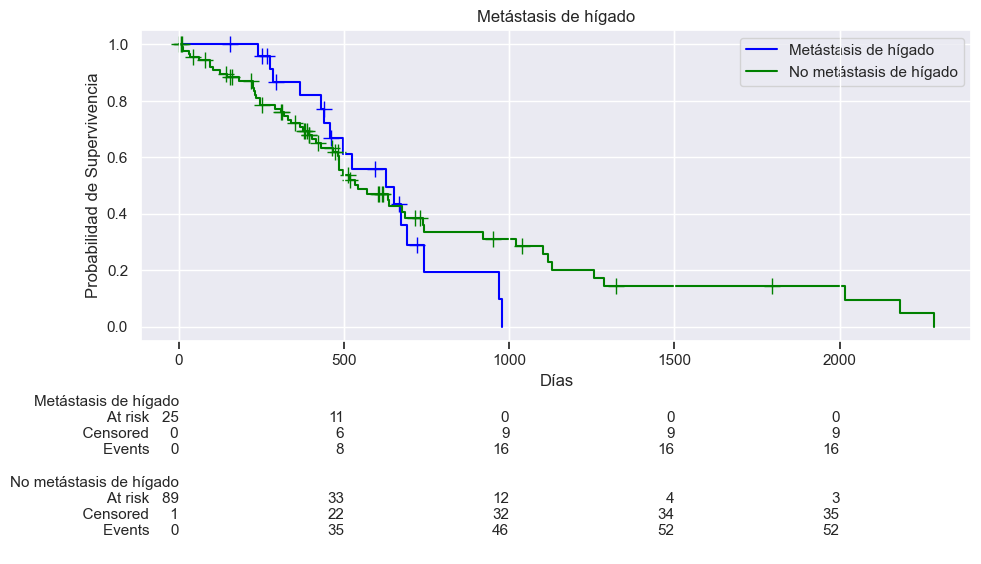

In [175]:
groups = diagnosis_primary['Liver']

mutated = (groups == 1)

prediction['Metástasis hígado'] = mutated
prediction['Metástasis hígado'] = prediction['Metástasis hígado'].fillna(False).astype(int)

print(f'Mutated: {mutated.sum()}')
print(f'No Mutated: {groups.shape[0] - mutated.sum()}')

kmf = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
ax = plt.gca()

kmf.fit(diagnosis_primary.loc[mutated, 'Overall Survival'], event_observed=diagnosis_primary.loc[mutated, 'Vital Status'], label="Metástasis de hígado")
kmf.plot_survival_function(ax=ax, ci_show=False, color='blue', show_censors=True)
print(f'Tiempo medio de supervivencia: {kmf.median_survival_time_:.0f} días')

kmf2.fit(diagnosis_primary.loc[~mutated, 'Overall Survival'], event_observed=diagnosis_primary.loc[~mutated, 'Vital Status'], label="No metástasis de hígado")
kmf2.plot_survival_function(ax=ax, ci_show=False, color='green', show_censors=True)
print(f'Tiempo medio de supervivencia: {kmf2.median_survival_time_:.0f} días')

ax.set_title('Metástasis de hígado')
ax.set_xlabel('Días')
ax.set_ylabel('Probabilidad de Supervivencia')

add_at_risk_counts(kmf, kmf2, ax=ax)
plt.tight_layout()
plt.show()

In [176]:
df = prediction[['Overall Survival', 'Vital Status', 'Metástasis hígado']]
cph = CoxPHFitter()
cph.fit(df, duration_col='Overall Survival', event_col='Vital Status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 115 total observations, 44 right-censored observations>
             duration col = 'Overall Survival'
                event col = 'Vital Status'
      baseline estimation = breslow
   number of observations = 115
number of events observed = 71
   partial log-likelihood = -262.40
         time fit was run = 2026-02-17 14:44:00 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
Metástasis hígado  0.09      1.10      0.30           -0.50            0.68                0.61                1.98

                   cmp to    z    p  -log2(p)
covariate                                    
Metástasis hígado    0.00 0.30 0.76      0.39
---
Concordance = 0.50
Partial AIC = 526.81
log-likelihood ratio test = 0.09 on 1 df
-log2(p) of ll-ratio test = 0.39

Mutated: 98
No Mutated: 17
Tiempo medio de supervivencia: 627 días
Tiempo medio de supervivencia: 568 días


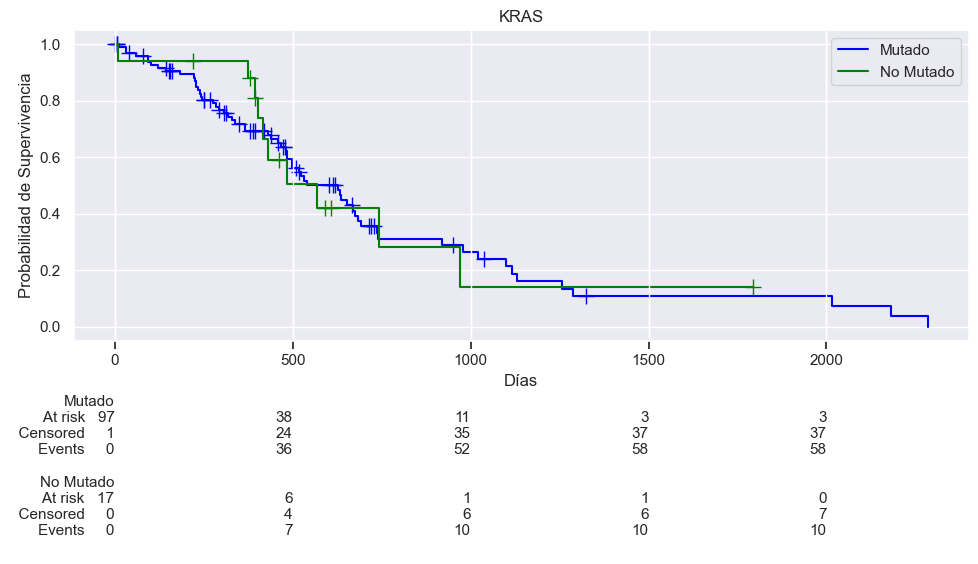

In [177]:
mutation_gene.loc[mutation_gene['Gene'] == 'KRAS'].transpose()
df = diagnosis_primary.merge(mutation_gene.loc[mutation_gene['Gene'] == 'KRAS'].transpose(), left_on='Patient Id', right_index=True, how='left')

groups = df[0]

mutated = (groups == 1)

prediction['KRAS'] = mutated
prediction['KRAS'] = prediction['KRAS'].fillna(False).astype(int)

print(f'Mutated: {mutated.sum()}')
print(f'No Mutated: {groups.shape[0] - mutated.sum()}')

kmf = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
ax = plt.gca()

kmf.fit(df.loc[mutated, 'Overall Survival'], event_observed=df.loc[mutated, 'Vital Status'], label="Mutado")
kmf.plot_survival_function(ax=ax, ci_show=False, color='blue', show_censors=True)
print(f'Tiempo medio de supervivencia: {kmf.median_survival_time_:.0f} días')

kmf2.fit(df.loc[~mutated, 'Overall Survival'], event_observed=df.loc[~mutated, 'Vital Status'], label="No Mutado")
kmf2.plot_survival_function(ax=ax, ci_show=False, color='green', show_censors=True)
print(f'Tiempo medio de supervivencia: {kmf2.median_survival_time_:.0f} días')

ax.set_title('KRAS')
ax.set_xlabel('Días')
ax.set_ylabel('Probabilidad de Supervivencia')

add_at_risk_counts(kmf, kmf2, ax=ax)
plt.tight_layout()
plt.show()

In [178]:
df = prediction[['Overall Survival', 'Vital Status', 'KRAS']]
cph = CoxPHFitter()
cph.fit(df, duration_col='Overall Survival', event_col='Vital Status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 115 total observations, 44 right-censored observations>
             duration col = 'Overall Survival'
                event col = 'Vital Status'
      baseline estimation = breslow
   number of observations = 115
number of events observed = 71
   partial log-likelihood = -262.39
         time fit was run = 2026-02-17 14:44:00 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
KRAS       0.08      1.08      0.24           -0.39            0.55                0.68                1.74

           cmp to    z    p  -log2(p)
covariate                            
KRAS         0.00 0.34 0.73      0.45
---
Concordance = 0.49
Partial AIC = 526.78
log-likelihood ratio test = 0.12 on 1 df
-log2(p) of ll-ratio test = 0.45

Mutated: 80
No Mutated: 35
Tiempo medio de supervivencia: 525 días
Tiempo medio de supervivencia: 969 días


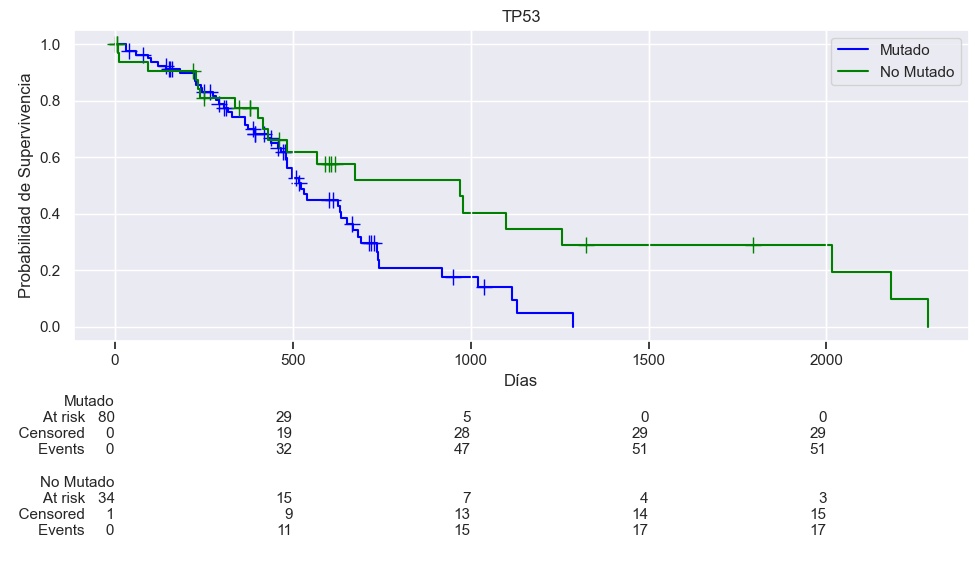

In [179]:
mutation_gene.loc[mutation_gene['Gene'] == 'TP53'].transpose()
df = diagnosis_primary.merge(mutation_gene.loc[mutation_gene['Gene'] == 'TP53'].transpose(), left_on='Patient Id', right_index=True, how='left')

groups = df[1]

mutated = (groups == 1)

prediction['TP53'] = mutated
prediction['TP53'] = prediction['TP53'].fillna(False).astype(int)

print(f'Mutated: {mutated.sum()}')
print(f'No Mutated: {groups.shape[0] - mutated.sum()}')

kmf = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
ax = plt.gca()

kmf.fit(df.loc[mutated, 'Overall Survival'], event_observed=df.loc[mutated, 'Vital Status'], label="Mutado")
kmf.plot_survival_function(ax=ax, ci_show=False, color='blue', show_censors=True)
print(f'Tiempo medio de supervivencia: {kmf.median_survival_time_:.0f} días')

kmf2.fit(df.loc[~mutated, 'Overall Survival'], event_observed=df.loc[~mutated, 'Vital Status'], label="No Mutado")
kmf2.plot_survival_function(ax=ax, ci_show=False, color='green', show_censors=True)
print(f'Tiempo medio de supervivencia: {kmf2.median_survival_time_:.0f} días')

ax.set_title('TP53')
ax.set_xlabel('Días')
ax.set_ylabel('Probabilidad de Supervivencia')

add_at_risk_counts(kmf, kmf2, ax=ax)
plt.tight_layout()
plt.show()

In [180]:
df = prediction[['Overall Survival', 'Vital Status', 'TP53']]
cph = CoxPHFitter()
cph.fit(df, duration_col='Overall Survival', event_col='Vital Status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 115 total observations, 44 right-censored observations>
             duration col = 'Overall Survival'
                event col = 'Vital Status'
      baseline estimation = breslow
   number of observations = 115
number of events observed = 71
   partial log-likelihood = -262.36
         time fit was run = 2026-02-17 14:44:01 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
TP53       0.10      1.11      0.24           -0.37            0.57                0.69                1.78

           cmp to    z    p  -log2(p)
covariate                            
TP53         0.00 0.41 0.68      0.56
---
Concordance = 0.50
Partial AIC = 526.73
log-likelihood ratio test = 0.17 on 1 df
-log2(p) of ll-ratio test = 0.56

Mutated: 27
No Mutated: 88
Tiempo medio de supervivencia: 684 días
Tiempo medio de supervivencia: 541 días


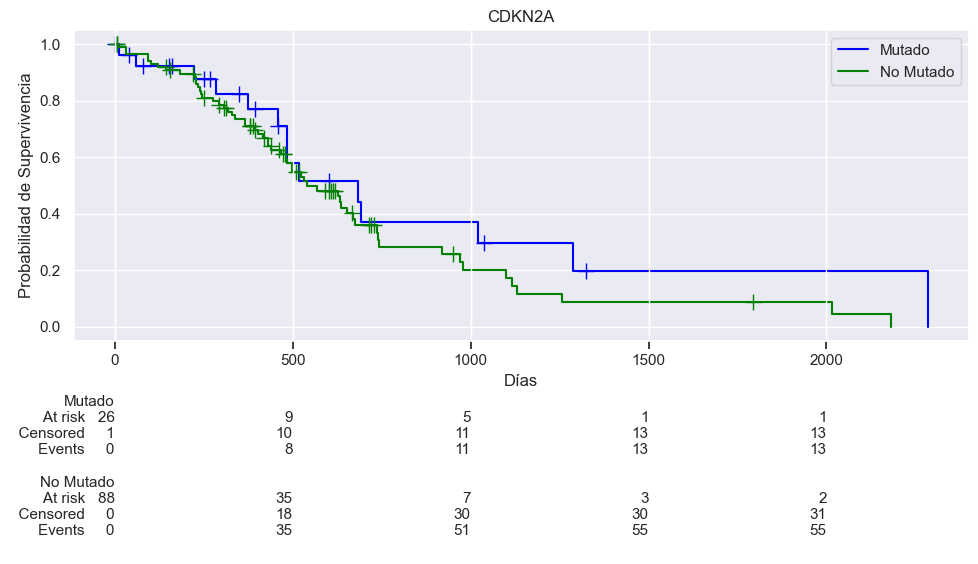

In [181]:
mutation_gene.loc[mutation_gene['Gene'] == 'CDKN2A'].transpose()
df = diagnosis_primary.merge(mutation_gene.loc[mutation_gene['Gene'] == 'CDKN2A'].transpose(), left_on='Patient Id', right_index=True, how='left')

groups = df[4]

mutated = (groups == 1)

prediction['CDKN2A'] = mutated
prediction['CDKN2A'] = prediction['CDKN2A'].fillna(False).astype(int)

print(f'Mutated: {mutated.sum()}')
print(f'No Mutated: {groups.shape[0] - mutated.sum()}')

kmf = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
ax = plt.gca()

kmf.fit(df.loc[mutated, 'Overall Survival'], event_observed=df.loc[mutated, 'Vital Status'], label="Mutado")
kmf.plot_survival_function(ax=ax, ci_show=False, color='blue', show_censors=True)
print(f'Tiempo medio de supervivencia: {kmf.median_survival_time_:.0f} días')

kmf2.fit(df.loc[~mutated, 'Overall Survival'], event_observed=df.loc[~mutated, 'Vital Status'], label="No Mutado")
kmf2.plot_survival_function(ax=ax, ci_show=False, color='green', show_censors=True)
print(f'Tiempo medio de supervivencia: {kmf2.median_survival_time_:.0f} días')

ax.set_title('CDKN2A')
ax.set_xlabel('Días')
ax.set_ylabel('Probabilidad de Supervivencia')

add_at_risk_counts(kmf, kmf2, ax=ax)
plt.tight_layout()
plt.show()

In [182]:
df = prediction[['Overall Survival', 'Vital Status', 'CDKN2A']]
cph = CoxPHFitter()
cph.fit(df, duration_col='Overall Survival', event_col='Vital Status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 115 total observations, 44 right-censored observations>
             duration col = 'Overall Survival'
                event col = 'Vital Status'
      baseline estimation = breslow
   number of observations = 115
number of events observed = 71
   partial log-likelihood = -261.84
         time fit was run = 2026-02-17 14:44:01 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
CDKN2A     0.42      1.52      0.36           -0.29            1.12                0.75                3.08

           cmp to    z    p  -log2(p)
covariate                            
CDKN2A       0.00 1.16 0.25      2.01
---
Concordance = 0.52
Partial AIC = 525.69
log-likelihood ratio test = 1.21 on 1 df
-log2(p) of ll-ratio test = 1.88

Mutated: 26
No Mutated: 89
Tiempo medio de supervivencia: 920 días
Tiempo medio de supervivencia: 525 días


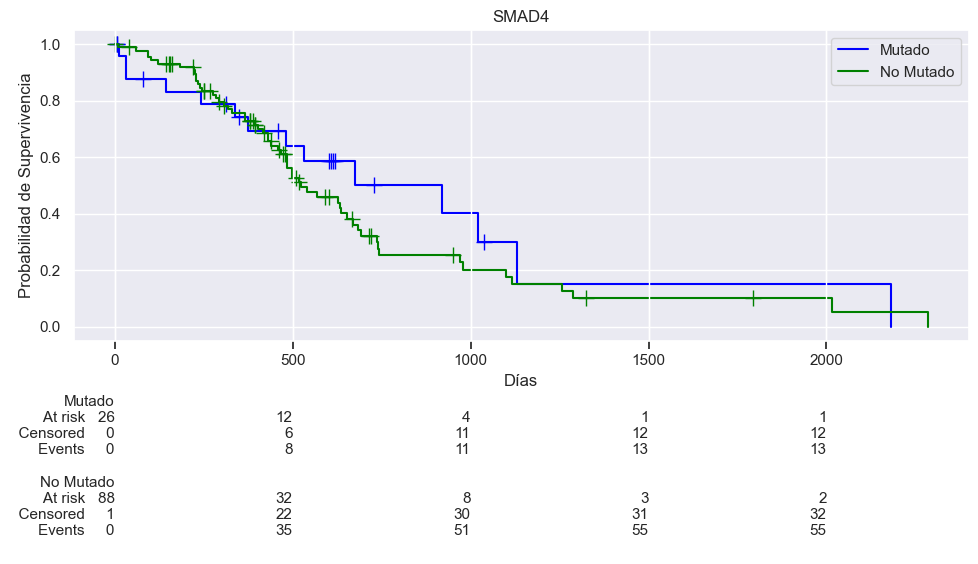

In [183]:
mutation_gene.loc[mutation_gene['Gene'] == 'SMAD4'].transpose()
df = diagnosis_primary.merge(mutation_gene.loc[mutation_gene['Gene'] == 'SMAD4'].transpose(), left_on='Patient Id', right_index=True, how='left')

groups = df[5]

mutated = (groups == 1)

prediction['SMAD4'] = mutated
prediction['SMAD4'] = prediction['SMAD4'].fillna(False).astype(int)

print(f'Mutated: {mutated.sum()}')
print(f'No Mutated: {groups.shape[0] - mutated.sum()}')

kmf = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
ax = plt.gca()

kmf.fit(df.loc[mutated, 'Overall Survival'], event_observed=df.loc[mutated, 'Vital Status'], label="Mutado")
kmf.plot_survival_function(ax=ax, ci_show=False, color='blue', show_censors=True)
print(f'Tiempo medio de supervivencia: {kmf.median_survival_time_:.0f} días')

kmf2.fit(df.loc[~mutated, 'Overall Survival'], event_observed=df.loc[~mutated, 'Vital Status'], label="No Mutado")
kmf2.plot_survival_function(ax=ax, ci_show=False, color='green', show_censors=True)
print(f'Tiempo medio de supervivencia: {kmf2.median_survival_time_:.0f} días')

ax.set_title('SMAD4')
ax.set_xlabel('Días')
ax.set_ylabel('Probabilidad de Supervivencia')

add_at_risk_counts(kmf, kmf2, ax=ax)
plt.tight_layout()
plt.show()

In [184]:
df = prediction[['Overall Survival', 'Vital Status', 'SMAD4']]
cph = CoxPHFitter()
cph.fit(df, duration_col='Overall Survival', event_col='Vital Status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 115 total observations, 44 right-censored observations>
             duration col = 'Overall Survival'
                event col = 'Vital Status'
      baseline estimation = breslow
   number of observations = 115
number of events observed = 71
   partial log-likelihood = -262.40
         time fit was run = 2026-02-17 14:44:02 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
SMAD4     -0.11      0.89      0.38           -0.85            0.63                0.43                1.87

           cmp to     z    p  -log2(p)
covariate                             
SMAD4        0.00 -0.30 0.76      0.39
---
Concordance = 0.49
Partial AIC = 526.81
log-likelihood ratio test = 0.09 on 1 df
-log2(p) of ll-ratio test = 0.40

In [185]:
save_data(prediction, '../data/processed/prediction.csv')